# Yelp Analysis Model Stacking

By Zoe Cooper

In [1]:
#import statements
import pandas as pd
import numpy as np
import enchant
import pprint as pprint
import json
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from functools import partial
from json import JSONDecoder
from sklearn.model_selection import StratifiedKFold
from pprint import pprint
from sklearn.model_selection import train_test_split
import nltk
import string
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
stemmer = SnowballStemmer("english")
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC #svm
ps = PorterStemmer()
from sklearn import preprocessing
from sklearn import naive_bayes
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from vecstack import stacking
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier



/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def print_multiclass_classif_error_report(y_test, preds):
    print('Accuracy: ' + str(accuracy_score(y_test, preds)))
    print('Avg. F1 (Micro): ' + str(f1_score(y_test, preds, average='micro')))
    print('Avg. F1 (Macro): ' + str(f1_score(y_test, preds, average='macro')))
    print('Avg. F1 (Weighted): ' + str(f1_score(y_test, preds, average='weighted')))
    print(classification_report(y_test, preds))
    print("Confusion Matrix:\n" + str(confusion_matrix(y_test, preds)))

Ensemble methods are an excellent way to improve predictive performance on your machine learning problems.
Stacked Generalization or stacking is an ensemble technique that uses a new model to learn how to best combine the predictions from two or more models trained on your dataset.
-meta learner

Its very difficult to distinguish between ratings varying by only 1 star. 

In [3]:
#read to file
file = []
for line in open("yelp_academic_dataset_review.json", 'r'):
    #data=json.load(f)
    file.append(json.loads(line))

In [4]:
#making dataframe
df = pd.DataFrame(file)

ones = df[df['stars'] == 1].sample(n=4000, random_state=1)
twos = df[df['stars'] == 2].sample(n=4000, random_state=1)
twees = df[df['stars'] == 3].sample(n=4000, random_state=1)
fours = df[df['stars'] == 4].sample(n=4000, random_state=1)
fives = df[df['stars'] == 5].sample(n=4000, random_state=1)

newdf = pd.concat([ones, twos, twees, fours, fives])


In [5]:
#dropping other columns:
olddata = df.drop(['business_id', 'date', 'review_id', 'type', 'user_id', 'votes'], axis=1)

In [6]:

#Defining preprocess function to clean up 'text' column:
def preprocess(raw_text):
    #remove punctuaction and put all lowercase
    text = raw_text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'[0-9]+', '', text)
    text = text.lower()
    #tokenize into Unigrams
    wordlist = text.split() #turns string into list #could use word tokenize w/ nltk too
    #remove non-english words
    d = enchant.Dict("en_US")
    texts = []
    #stem words
    for word in wordlist:
        if d.check(word):
            texts.append(ps.stem(word))
    #remove stop words
    texts = [word for word in texts if word not in stopwords.words("english")]
    text = ' '.join(texts) #convert back to string
    return text

In [7]:
#setting y


y=newdf['stars']

print(y.unique())

[1 2 3 4 5]


In [8]:
#putting df column as corpus
raw_corpus = newdf['text']



In [9]:
#Preprocessing each review in corpus, above is function for that:
l = []
for review in raw_corpus:
    l.append(preprocess(review))


In [10]:
#dtm with pandas and sklearn
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(l)
df = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names())
#print(df)

In [11]:
#tf-idf matrix
vec = TfidfVectorizer()
X = vec.fit_transform(l)
df2 = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())


In [66]:
x_train, x_test, y_train, y_test = train_test_split(df2,y,test_size=0.2) #20 percent is test set
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

16000
4000
16000
4000


The function below makes predictions on n-folds of train and test dataset. It returns the predictions for train and test for each model. This way we can use them with the next model.

In [13]:
#stacking function
def Stacking(model,train,y,test,n_fold):
    folds=StratifiedKFold(n_splits=n_fold,random_state=1)
    test_pred=np.empty((test.shape[0],1),int)
    train_pred=np.empty((0,1),int)
    for train_indices,val_indices in folds.split(train,y.values):
        x_train,x_val=train.iloc[train_indices],train.iloc[val_indices]
        y_train,y_val=y.iloc[train_indices],y.iloc[val_indices]
        model.fit(X=x_train,y=y_train)
        train_pred=np.append(train_pred,model.predict(x_val))
        test_pred=np.append(test_pred,model.predict(test))
    return test_pred,train_pred


Creating two base models – svc and kNN:

In [29]:
model1 = LinearSVC()


test_pred1 ,train_pred1=Stacking(model=model1,n_fold=10, train=x_train,test=x_test,y=y_train)


train_pred1=pd.DataFrame(train_pred1)
test_pred1=pd.DataFrame(test_pred1[40000:])


In [18]:
model2 = KNeighborsClassifier()
#XGBClassifier(random_state=1, n_jobs=-1, learning_rate=0.1, n_estimators=100, max_depth=3)

test_pred2 ,train_pred2=Stacking(model=model2,n_fold=10,train=x_train,test=x_test,y=y_train)

train_pred2=pd.DataFrame(train_pred2)
test_pred2=pd.DataFrame(test_pred2)


Making a third model, naive bayes, on the predictions of the svm and xgb models.

In [27]:

df = pd.concat([train_pred1, train_pred2], axis=1)
df_test = pd.concat([test_pred1, test_pred2], axis=1)

#model = LogisticRegression(random_state=1)
model = naive_bayes.GaussianNB()
model.fit(df,y_train)
#finaldftest = df_test[df_test.notnull()]

df_test = df_test.dropna()
print(df)
print(df_test)


print(y_test)
#dataframe = pd.merge([df_test, y_test])

print(len(df_test))
print(len(y_test))



print(model.score(df_test[40000:], y_test))




       0  0
0      5  3
1      3  1
2      1  1
3      1  1
4      2  3
5      5  1
6      1  1
7      4  1
8      1  3
9      5  1
10     5  3
11     2  2
12     3  3
13     1  3
14     1  1
15     1  3
16     4  3
17     4  3
18     4  3
19     5  1
20     3  3
21     5  1
22     1  3
23     5  3
24     3  3
25     1  3
26     4  3
27     5  1
28     5  3
29     2  3
...   .. ..
15970  3  4
15971  5  4
15972  2  4
15973  1  4
15974  4  4
15975  5  4
15976  1  4
15977  3  4
15978  2  4
15979  3  1
15980  1  4
15981  1  1
15982  3  4
15983  5  4
15984  2  4
15985  2  1
15986  2  4
15987  2  4
15988  5  1
15989  1  4
15990  2  4
15991  4  4
15992  4  2
15993  4  4
15994  5  1
15995  3  4
15996  3  1
15997  5  1
15998  1  4
15999  5  4

[16000 rows x 2 columns]
Empty DataFrame
Columns: [0, 0]
Index: []
         stars
902272       3
1510810      5
495040       1
1033119      2
1550655      5
1295309      1
1271387      3
205986       3
627046       5
566566       5
1467556      3
1251106 

ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.

tp: 
0       4
1       5
2       1
3       1
4       5
5       1
6       4
7       3
8       5
9       4
10      5
11      4
12      3
13      1
14      2
15      5
16      4
17      3
18      2
19      2
20      1
21      5
22      3
23      4
24      5
25      2
26      3
27      2
28      3
29      2
       ..
3970    2
3971    1
3972    2
3973    2
3974    3
3975    4
3976    3
3977    3
3978    2
3979    4
3980    4
3981    4
3982    1
3983    4
3984    1
3985    5
3986    2
3987    5
3988    2
3989    5
3990    1
3991    2
3992    4
3993    2
3994    1
3995    2
3996    4
3997    3
3998    5
3999    3
Name: 0, Length: 4000, dtype: int64
yt: 
114533     2
870746     1
1379432    5
903577     1
995840     1
467948     3
1537182    5
1299489    4
1233614    4
503051     1
699606     5
796968     3
834500     3
148637     2
1216338    3
153896     4
716242     4
1094147    1
307085     4
1004881    5
525702     3
190222     5
968861     4
1434872    1
91939      4
1393896    1
70802 

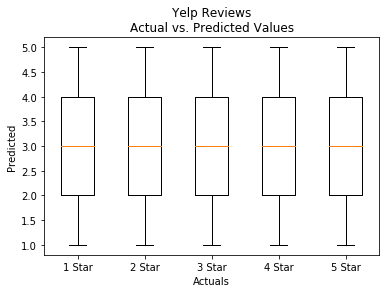

In [77]:
#BoxPLOT



tp = test_pred1.iloc[:,0]
print("tp: ")
print(tp)


y_test = pd.DataFrame(y_test)

yt = y_test.iloc[:,0]
print("yt: ")
print(yt)
ytnew = yt.reset_index(drop=True)
print("ytnew: ")
print(ytnew)

data = pd.DataFrame({"Actuals" : tp, "Predicts" : ytnew})


print(data)
#row where actuals only equal ones
one = data.loc[data['Actuals'] == 1];
#get rid of actuals since we now know this our 'x' when plotting
one = one.drop(['Actuals'], axis = 1)
#turn into list
one = one['Predicts'].tolist();  
#twos
two = data.loc[data['Actuals'] == 2];
#get rid of actuals, since we now know this our 'x' when plotting
two = two.drop(['Actuals'], axis = 1);
#turn into list
two = two['Predicts'].tolist();   
#threes
three = data.loc[data['Actuals'] == 3];
#get rid of actuals, since we now know this our 'x' when plotting
three = three.drop(['Actuals'], axis = 1) 
#turn into list 
three = three['Predicts'].tolist(); 
#fours
four = data.loc[data['Actuals'] == 4];
#get rid of actuals, since we now know this our 'x' when plotting
four = four.drop(['Actuals'], axis = 1);
#turn into list
four = four['Predicts'].tolist();  
#fives
five = data.loc[data['Actuals'] == 5];
#get rid of actuals, since we now know this our 'x' when plotting
five = five.drop(['Actuals'], axis = 1);
#turn into list
five= five['Predicts'].tolist(); 

#bring it together 
plotData = [one, two, three, four, five];
#print(plotData); 

#plots
fig1, ax1 = plt.subplots();
ax1.set_title('Yelp Reviews\nActual vs. Predicted Values'); 
ax1.set_xlabel('Actuals');
ax1.set_ylabel('Predicted');

ax1.boxplot(plotData);
plt.xticks([1, 2, 3, 4, 5], ["1 Star", "2 Star", "3 Star", "4 Star", "5 Star"]);
plt.show();




Accuracy is a crude metric–there are of course finer-grained evaluation methods.It’s likely that some classes are ‘easier’ to predict than others, so we want to look at how well the classifier can predict each class (for example, only 5-star reviews) individually. Focus on precision and recall. We can measure both at the same time using an F1 Score, which measures both as a single metric. It seems like it's easiest to predict a '4' here.

With five rating classes, random guessing would be correct only 20% of the time. Next time... predicting a positive or negative review could be easier, more sentiment analysis with binary classification. Accuracy would probably be a lot higher. 